In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn

from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
RESDIR='../output/220906_analysis/'

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


## reloading datasets

In [144]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

In [3]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [4]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

## Merging w/ baseline scores

In [5]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [6]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

## quick roc check

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

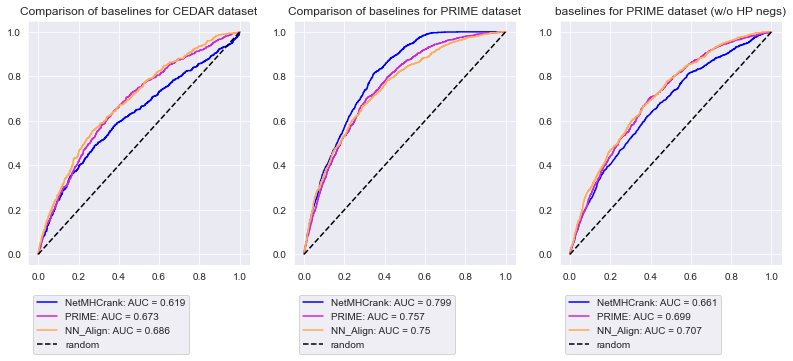

In [7]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)
a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

## BASELINE ROCS

In [8]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score

def plot_baseline_roc(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(prime['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')

    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')


# Results

## load pkls and dfs

In [9]:
# Dataframes with scores (OLD-REDONE)
df_log = pd.read_csv(f'{RESDIR}run_220905_11h48m21s_log_redo/df_results_log.csv')
df_rf = pd.read_csv(f'{RESDIR}run_220906_10h29m43s_rf_redo/df_results_rf.csv')
df_xgb = pd.concat([pd.read_csv(f'{RESDIR}run_220905_10h44m21s_xgb_hp_redo/df_results_xgb_hp.csv'),
                    pd.read_csv(f'{RESDIR}run_220905_10h44m20s_xgb_normal_redo/df_results_xgb_normal.csv')])

df_xgb_hp = pd.read_csv(f'{RESDIR}run_220905_10h44m21s_xgb_hp_redo/df_results_xgb_hp.csv')
df_xgb_normal = pd.read_csv(f'{RESDIR}run_220905_10h44m20s_xgb_normal_redo/df_results_xgb_normal.csv')
df_nn = pd.read_csv(f'{RESDIR}run_220826_13h45m05s_nn/df_results_nn.csv')
# new runs
df_rf_new = pd.read_csv(f'{RESDIR}run_220904_18h24m51s_new_rf/df_results_rf.csv').replace({'cedar_virus':'cedar_virus_new',
                                                                                           'RF':'RF_new'})
df_xgb_new = pd.read_csv(f'{RESDIR}run_220904_18h10m26s_new_xgb/df_results_xgb.csv').replace({'cedar_virus':'cedar_virus_new',
                                                                                              'XGB':'XGB_new'})

# Merging
df= pd.concat([df_log, df_rf, df_xgb, df_nn, df_rf_new, df_xgb_new]).reset_index().rename(columns={'index':'list_idx'})
df['encoding']= df.apply(lambda x: x['blsm'] if x['encoding']=='blosum' else 'onehot', axis=1)

In [10]:
# Pickles with results&curves
cedar_log = pkl_load(f'{RESDIR}run_220905_11h48m21s_log_redo/cedar_results_log.pkl')
prime_log = pkl_load(f'{RESDIR}run_220905_11h48m21s_log_redo/prime_results_log.pkl')
cedar_rf = pkl_load(f'{RESDIR}run_220906_10h29m43s_rf_redo/cedar_results_rf.pkl')
prime_rf = pkl_load(f'{RESDIR}run_220906_10h29m43s_rf_redo/prime_results_rf.pkl')
cedar_xgb_hp = pkl_load(f'{RESDIR}run_220905_10h44m21s_xgb_hp_redo/cedar_results_xgb_hp.pkl')
prime_xgb_hp = pkl_load(f'{RESDIR}run_220905_10h44m21s_xgb_hp_redo/prime_results_xgb_hp.pkl')
cedar_xgb_normal = pkl_load(f'{RESDIR}run_220905_10h44m20s_xgb_normal_redo/cedar_results_xgb_normal.pkl')
prime_xgb_normal = pkl_load(f'{RESDIR}run_220905_10h44m20s_xgb_normal_redo/prime_results_xgb_normal.pkl')
cedar_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/cedar_results_nn.pkl')
prime_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/prime_results_nn.pkl')
# NEW curves
cedar_rf_new = pkl_load(f'{RESDIR}run_220904_18h24m51s_new_rf/cedar_results_rf.pkl')
prime_rf_new = pkl_load(f'{RESDIR}run_220904_18h24m51s_new_rf/prime_results_rf.pkl')
cedar_xgb_new = pkl_load(f'{RESDIR}run_220904_18h10m26s_new_xgb/cedar_results_xgb.pkl')
prime_xgb_new = pkl_load(f'{RESDIR}run_220904_18h10m26s_new_xgb/prime_results_xgb.pkl')


In [11]:
df.sample(5)

,list_idx,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,score_avg_prime_prauc,score_concat_prime_prauc,score_avg_cedar_prauc,score_concat_cedar_prauc,lr,wd,hyperparams
444,44,cedar,RF,KL,12,BL62FREQ,False,True,False,False,True,0.686807,0.541526,0.036877,0.686697,0.541398,0.036997,0.594587,0.545512,0.053571,0.596810,0.536462,0.055556,0.680242,0.553338,0.027662,BL62FREQ,0.432020,0.431304,0.313851,0.294760,NaN,NaN,NaN
493,93,cedar,RF,Mask,12,BL62LO,True,True,False,False,False,0.676774,0.536962,0.013718,0.676590,0.536883,0.013808,0.620246,0.570024,0.000000,0.620321,0.543871,0.000000,0.679130,0.552629,0.011114,BL62LO,0.413646,0.412928,0.370843,0.309450,NaN,NaN,NaN
896,2,cedar,XGB,Shannon,12,onehot,False,True,False,False,True,0.692409,0.552051,0.210454,0.692374,0.552066,0.210570,0.623945,0.570974,0.044444,0.664373,0.560224,0.051282,0.692527,0.565428,0.187889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,6,cedar_hp_rank_low,XGB,Shannon,12,onehot,False,False,False,False,True,0.657604,0.548381,0.035690,0.657537,0.548335,0.035747,0.650262,0.547260,0.044791,0.648341,0.546390,0.044248,0.690798,0.572088,0.054359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,33,cedar,RF,Mask,12,onehot,True,False,False,False,False,0.646784,0.525724,0.000343,0.646699,0.525732,0.000343,0.645067,0.531906,0.000000,0.672923,0.542115,0.000000,0.663427,0.536037,0.000317,NaN,0.380591,0.380128,0.342189,0.327676,NaN,NaN,NaN


## hla distr check

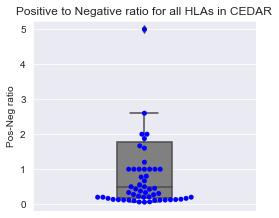

In [12]:
# POS-NEG ratio boxplot
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
f,a = plt.subplots(1,1, figsize=(4,3.5))
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a)
sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a, saturation=0,
           width=0.25)
a.set_title('Positive to Negative ratio for all HLAs in CEDAR')
a.set_xlabel('')
pd.options.display.max_rows=10 

In [13]:
len(gb_count.query('agg_label==1')), len(gb_count.query('agg_label==0')), len(gb_count.reset_index(level=1).index.unique())

(63, 52, 63)

Text(0.5, 1.0, '% of Positive peptides vs number of positive peptides in dataset per HLA')

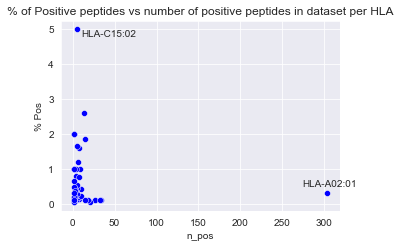

In [14]:
f,a = plt.subplots(1,1, figsize=(5,3.5))
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios.rename(columns={'Pos-Neg ratio':'% Pos'}), left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= '% Pos')

max_x = npos_ratios.iloc[npos_ratios['n_pos'].argmax()].name
max_y = npos_ratios.iloc[npos_ratios['% Pos'].replace(np.inf, 0).argmax()].name
# label outlier in x
a.text(npos_ratios.loc[max_x]['n_pos']-30, npos_ratios.loc[max_x]['% Pos']+0.2, max_x)
# label outlier in y
a.text(npos_ratios.loc[max_y]['n_pos']+5, npos_ratios.loc[max_y]['% Pos']-0.2, max_y)
a.set_title('% of Positive peptides vs number of positive peptides in dataset per HLA')

### Checking CEDAR vs PRIME performance scatter

In [15]:
df.trainset.unique()

array(['cedar', 'cedar_hp_rank_low', 'cedar_hp_rank_uni', 'cedar_virus',
       'prime', 'virus', 'cedar_virus_new'], dtype=object)

Text(0.5, 1.0, 'Concat CEDAR test AUC vs Concat PRIME AUC\n for different training sets')

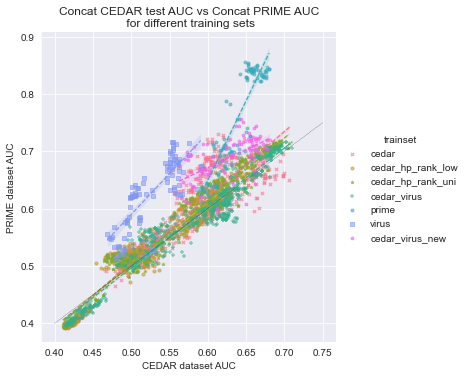

In [16]:
sns.set_palette(HSV)
f = plt.Figure(figsize=(7,6))

# f.set_axis_labels('CEDAR dataset AUC', 'PRIME dataset AUC')
sns.lmplot(data=df, x = 'score_concat_cedar_auc', y = 'score_concat_prime_auc', hue='trainset',
           markers = ['x', 'o', '*', '+', '8', 's', 'p'],  
           scatter_kws={"alpha":0.55,"s":10}, line_kws={'lw':1.2,'ls':'--'})

plt.plot([0.4,0.75],[0.4,.75], lw=0.25, ls='--', c='k')
plt.xlim = [0.4, 0.75]
plt.ylim = [0.4, 0.75]
plt.xlabel('CEDAR dataset AUC')
plt.ylabel('PRIME dataset AUC')

plt.title('Concat CEDAR test AUC vs Concat PRIME AUC\n for different training sets')

## check top values

In [17]:
best_log_idx = df_log.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_log = cedar_log[best_log_idx]
best_prime_log = prime_log[best_log_idx]

best_rf_idx = df_rf.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_rf = cedar_rf[best_rf_idx]
best_prime_rf = prime_rf[best_rf_idx]

best_xgb_hp_idx = df_xgb_hp.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_xgb_hp = cedar_xgb_hp[best_xgb_hp_idx]
best_prime_xgb_hp = prime_xgb_hp[best_xgb_hp_idx]

best_xgb_normal_idx = df_xgb_normal.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_xgb_normal = cedar_xgb_normal[best_xgb_normal_idx]
best_prime_xgb_normal = prime_xgb_normal[best_xgb_normal_idx]

best_nn_idx = df_nn.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_nn = cedar_nn[best_nn_idx]
best_prime_nn = prime_nn[best_nn_idx]

best_rf_new_idx = df_rf_new.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_rf_new = cedar_rf_new[best_rf_new_idx]
best_prime_rf_new = prime_rf_new[best_rf_new_idx]

best_xgb_new_idx = df_xgb_new.sort_values('score_concat_cedar_auc', ascending=False).head(1).index.item()
best_cedar_xgb_new = cedar_xgb_new[best_xgb_new_idx]
best_prime_xgb_new = prime_xgb_new[best_xgb_new_idx]

In [94]:
# Get the columns
hyperparams_col = df.columns[:10].join(['blsm'], how='outer').drop(['max_len', 'mask'])
scores_col = ['score_concat_prime_auc', 'score_concat_cedar_auc', 'score_avg_valid_auc']
columns = hyperparams_col.join(scores_col, how='outer')
# Get a simplified DF with less information
df_simple = df[columns].reset_index(drop=True)
# Query the top 25 AUC PER MODEL for each metric chosen (cedar auc, prime auc, validation auc)

cedar_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_cedar_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_cedar_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'}).sort_values('score_concat_cedar_auc', ascending=False)
prime_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_prime_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_prime_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'}).sort_values('score_concat_prime_auc', ascending=False)

valid_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_avg_valid_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_avg_valid_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'}).sort_values('score_avg_valid_auc', ascending=False)

## retry training one of the best models for XGB and see what happened on PRIME eval

In [168]:
xgb_new_test = pkl_load('../output/tuning/run_220902_14h13m49s_Xgb_tuning_new/tune_results_models.pkl')
best_xgb_new_train = pkl_load('../output/tuning/run_220902_14h13m49s_Xgb_tuning_new/trainsetprime_modelXGB_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropFalse_remove_pepFalse_standardizeTrue.pkl')
hp = xgb_new_test['XGBClassifier'][1][2].pop('best_params')
hp['max_depth'] = int(hp['max_depth'])
hp['n_estimators'] = int(hp['n_estimators'])
encoding_kwargs= xgb_new_test['XGBClassifier'][1][2]
encoding_kwargs.pop('trainset'); encoding_kwargs.pop('model'); encoding_kwargs.pop('weight')
type(best_xgb_new_train)

dict

In [169]:
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
encoding_kwargs['blosum_matrix']=None
model = XGBClassifier(tree_method='gpu_hist', n_jobs=2, **hp)
retrained_xgb, xgb_train_metrics, xgb_test_metrics = nested_kcv_train_sklearn(prime_fold, model, ics_shannon, encoding_kwargs)

Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

In [177]:
mean_fpr, mean_tpr, lower, upper, mean_auc = get_mean_roc_curve(xgb_test_metrics)

Text(0.5, 1.0, 'XGB Trained on Prime, eval on PRIME test folds\nWeight=Shannon, Encoding=Onehot, Add Rank=True')

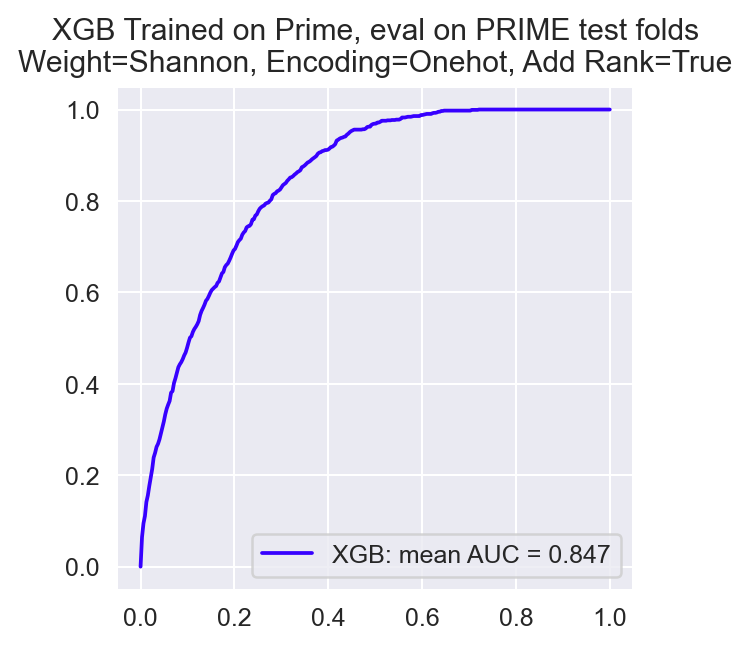

In [183]:
f,a = plt.subplots(1,1, figsize=(3.7,3.7))
plt.plot(mean_fpr, mean_tpr, label = f'XGB: mean AUC = {round(mean_auc,3)}')
a.legend()
a.set_title('XGB Trained on Prime, eval on PRIME test folds\nWeight=Shannon, Encoding=Onehot, Add Rank=True')

## TOP params

### Check overall best

In [192]:
df['cedar_concat_mean_rocpr_auc'] = df.apply(lambda x: 0.5*(x['score_concat_cedar_auc']+x['score_concat_cedar_prauc']), axis=1)
df['prime_concat_mean_rocpr_auc'] = df.apply(lambda x: 0.5*(x['score_concat_prime_auc']+x['score_concat_prime_prauc']), axis=1)

In [187]:
overall_best_prime = df.query('trainset!="prime"').sort_values('score_concat_prime_auc', ascending=False).head(3)
overall_best_cedar = df.sort_values('score_concat_cedar_auc', ascending=False).head(10)
overall_best_valid = df.sort_values('score_avg_valid_auc', ascending=False).head(3)

In [191]:
overall_best_cedar

,list_idx,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,score_avg_prime_prauc,score_concat_prime_prauc,score_avg_cedar_prauc,score_concat_cedar_prauc,lr,wd,hyperparams
614,214,cedar_virus,RF,None,12,onehot,False,True,False,False,True,0.704900,0.563836,0.266226,0.704856,0.563787,0.266305,0.711476,0.570187,0.197307,0.710422,0.569177,0.195062,0.712884,0.567965,0.230086,NaN,0.478926,0.478752,0.381190,0.369026,NaN,NaN,NaN
2897,11,cedar,XGB_new,None,12,onehot,False,False,False,False,True,0.650123,0.553221,0.261916,0.650096,0.553201,0.261989,0.687936,0.542562,0.189784,0.706496,0.558084,0.234043,0.668148,0.544561,0.228344,NaN,0.300091,0.299459,0.345138,0.384755,NaN,NaN,NaN
515,115,cedar_hp_rank_uni,RF,None,12,onehot,False,True,True,False,False,0.714174,0.554149,0.138453,0.714124,0.554195,0.138485,0.705824,0.584280,0.116017,0.706134,0.584560,0.116183,0.824185,0.648271,0.137900,NaN,0.457826,0.457464,0.398092,0.391467,NaN,NaN,NaN
517,117,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,False,0.706166,0.557511,0.125292,0.706140,0.557470,0.125328,0.703175,0.577985,0.116760,0.704180,0.579870,0.117155,0.831713,0.646452,0.123519,NaN,0.462233,0.462146,0.385585,0.382953,NaN,NaN,NaN
516,116,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,True,0.706129,0.557448,0.125287,0.706108,0.557403,0.125318,0.703338,0.578641,0.119195,0.704149,0.580079,0.119611,0.831797,0.646562,0.121575,NaN,0.462409,0.462207,0.386395,0.382553,NaN,NaN,NaN
613,213,cedar_virus,RF,None,12,onehot,False,True,True,False,False,0.715685,0.559939,0.185020,0.715658,0.559986,0.185218,0.704050,0.575994,0.124322,0.701930,0.572996,0.123626,0.711005,0.571061,0.139502,NaN,0.474389,0.474404,0.390209,0.375099,NaN,NaN,NaN
597,197,cedar_virus,RF,Shannon,12,onehot,False,True,True,False,False,0.706249,0.569864,0.267420,0.706248,0.569884,0.267504,0.703735,0.574947,0.199626,0.701895,0.572076,0.201005,0.707088,0.569310,0.210148,NaN,0.487367,0.487284,0.389187,0.375703,NaN,NaN,NaN
612,212,cedar_virus,RF,None,12,onehot,False,True,True,False,True,0.715690,0.559980,0.184312,0.715671,0.560042,0.184474,0.703883,0.576292,0.124535,0.701839,0.573208,0.123796,0.711155,0.570692,0.137698,NaN,0.474389,0.474438,0.391468,0.375333,NaN,NaN,NaN
596,196,cedar_virus,RF,Shannon,12,onehot,False,True,True,False,True,0.706122,0.569380,0.266639,0.706146,0.569424,0.266747,0.703807,0.575395,0.196549,0.701794,0.572088,0.198492,0.707067,0.569671,0.212424,NaN,0.486713,0.486730,0.389545,0.376639,NaN,NaN,NaN
2705,11,cedar,RF_new,None,12,onehot,False,False,False,False,True,0.662789,0.567996,0.183196,0.662778,0.567967,0.183268,0.672726,0.577270,0.106753,0.700057,0.578278,0.135135,0.691628,0.558859,0.120150,NaN,0.346547,0.346397,0.394323,0.413672,NaN,NaN,NaN


In [190]:
print('overall_best_prime')
display(overall_best_prime)
print('overall_best_cedar')
display(overall_best_cedar.iloc[[0,2]])
print('overall_best_valid')
display(overall_best_valid)

overall_best_prime


,list_idx,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,score_avg_prime_prauc,score_concat_prime_prauc,score_avg_cedar_prauc,score_concat_cedar_prauc,lr,wd,hyperparams
3058,172,cedar_virus_new,XGB_new,Mask,12,BL62FREQ,True,True,True,False,True,0.756802,0.639141,0.421916,0.756913,0.639094,0.421945,0.644214,0.571563,0.242109,0.643793,0.571763,0.244521,0.706363,0.591560,0.311001,BL62FREQ,0.479378,0.479225,0.348568,0.347405,NaN,NaN,NaN
3046,160,cedar_virus_new,XGB_new,Shannon,12,BL62FREQ,False,True,True,False,True,0.750260,0.606789,0.310807,0.750272,0.606423,0.310821,0.647069,0.560089,0.193149,0.646517,0.561659,0.193865,0.711747,0.587083,0.281334,BL62FREQ,0.430332,0.429165,0.331195,0.328655,NaN,NaN,NaN
3030,144,cedar_virus_new,XGB_new,Shannon,12,onehot,False,True,True,False,True,0.744210,0.609324,0.346168,0.744126,0.608382,0.346276,0.662381,0.572165,0.274431,0.662305,0.572368,0.275626,0.740300,0.602685,0.331649,NaN,0.432587,0.430818,0.349675,0.350735,NaN,NaN,NaN


overall_best_cedar


,list_idx,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,score_avg_prime_prauc,score_concat_prime_prauc,score_avg_cedar_prauc,score_concat_cedar_prauc,lr,wd,hyperparams
614,214,cedar_virus,RF,None,12,onehot,False,True,False,False,True,0.704900,0.563836,0.266226,0.704856,0.563787,0.266305,0.711476,0.570187,0.197307,0.710422,0.569177,0.195062,0.712884,0.567965,0.230086,NaN,0.478926,0.478752,0.381190,0.369026,NaN,NaN,NaN
515,115,cedar_hp_rank_uni,RF,None,12,onehot,False,True,True,False,False,0.714174,0.554149,0.138453,0.714124,0.554195,0.138485,0.705824,0.584280,0.116017,0.706134,0.584560,0.116183,0.824185,0.648271,0.137900,NaN,0.457826,0.457464,0.398092,0.391467,NaN,NaN,NaN


overall_best_valid


,list_idx,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,score_avg_prime_prauc,score_concat_prime_prauc,score_avg_cedar_prauc,score_concat_cedar_prauc,lr,wd,hyperparams
2982,96,virus,XGB_new,Shannon,12,onehot,False,True,True,False,True,0.705907,0.573058,0.406485,0.705752,0.573014,0.406447,0.553927,0.522008,0.270950,0.553969,0.522065,0.270916,0.858519,0.675590,0.517912,NaN,0.361381,0.361040,0.231704,0.231519,NaN,NaN,NaN
2986,100,virus,XGB_new,KL,12,onehot,False,True,True,False,True,0.697839,0.569474,0.398706,0.697675,0.569266,0.398571,0.551334,0.519767,0.270279,0.551261,0.519816,0.270306,0.858007,0.676230,0.511390,NaN,0.351563,0.351167,0.228157,0.227711,NaN,NaN,NaN
2987,101,virus,XGB_new,KL,12,onehot,False,True,False,False,True,0.681213,0.563095,0.375483,0.681085,0.562639,0.375327,0.550900,0.517719,0.255824,0.550865,0.517854,0.255820,0.856325,0.674334,0.509463,NaN,0.334477,0.333537,0.224631,0.224272,NaN,NaN,NaN


In [90]:
print('\ncedar_auc')
display(df_simple.loc[cedar_auc['best_idx']].groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nprime_auc')
display(df_simple.loc[prime_auc['best_idx']].groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nvalid_auc')
display(df_simple.loc[valid_auc['best_idx']].groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))



cedar_auc


model
add_rank add_aaprop weight  encoding       
True     True       Shannon onehot       14
                    KL      onehot       13
         False      None    onehot       13
         True       None    onehot       11
         False      KL      onehot       10
         True       None    BL62LO       10
         False      Shannon onehot       10
         True       Shannon BL62FREQ      8
         False      None    BL62LO        8
         True       Mask    onehot        6


prime_auc


model
add_rank add_aaprop weight  encoding       
True     True       None    onehot        9
                            BL62LO        9
         False      None    BL62LO        9
                            onehot        8
                            BL62FREQ      8
                    Shannon onehot        7
         True       Shannon BL62FREQ      7
                    Mask    onehot        7
                    KL      onehot        7
                            BL62FREQ      7


valid_auc


model
add_rank add_aaprop weight  encoding       
True     False      None    BL62LO       12
                            onehot       12
                    KL      onehot       11
                    Shannon onehot       10
         True       Shannon onehot        9
                    None    onehot        9
                    KL      onehot        9
                    Shannon BL62FREQ      8
         False      Mask    onehot        7
                    None    BL62FREQ      7

## TOP method

In [ ]:
def get_top_100(df, param_col, score_col='score_concat_cedar_auc', param_value=None):
    """
    Gets the top 100 best performance given a score_col 
    and either query a given param (ex : param_col='standardize', param_value=True) or returns a dict of the top for all possible param values
    """
    if param_value is None:
        values = df[param_col].unique()
        queries = [df.query(f'{param_col}==@val').sort_values(score_col, ascending=False) for val in values]
        return {val: q.head(min(100, len(q))) for q,val in zip(queries, values)}
    else:
        query = df.query(f'{param_col}==@param_value')
        return query.sort_values(score_col, ascending=False).head(min(100, len(query)))

In [ ]:
top_100_std = get_top_100(df_simple, 'standardize', 'score_concat_cedar_auc', True)
top_100_std.groupby(['encoding', 'add_rank', 'model']).count()

## trainsets

In [ ]:
# Top Encoding and Weighting
sns.set_palette(HSV)

f,a = plt.subplots(1,2, figsize=(10,5), sharey=True)

f.suptitle('Comparison of encoding and weighting schemes\nWithout physicochemical properties added')
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_cedar_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1)
# a[0].legend(loc = 'upper right')#bbox_to_anchor=(1.25,1))
a[0].legend([],[], frameon=False)
a[0].set_title('Evaluation metric: CEDAR test AUC\n Using top 100 performance for other parameters')

# on PRIME
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_prime_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_prime_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1)# add_legend=False)
a[1].legend(bbox_to_anchor=(1.05,1))
a[1].set_title('Evaluation metric: PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

### Top encoding-weighting pair

In [ ]:
# Top Encoding and Weighting
sns.set_palette(HSV)

f,a = plt.subplots(1,2, figsize=(10,5), sharey=True)

f.suptitle('Comparison of encoding and weighting schemes\nWithout physicochemical properties added')
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_cedar_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1)
# a[0].legend(loc = 'upper right')#bbox_to_anchor=(1.25,1))
a[0].legend([],[], frameon=False)
a[0].set_title('Evaluation metric: CEDAR test AUC\n Using top 100 performance for other parameters')

# on PRIME
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_prime_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_prime_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1)# add_legend=False)
a[1].legend(bbox_to_anchor=(1.05,1))
a[1].set_title('Evaluation metric: PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

Seems like KL and None x Onehot is the best combination of weighting and encoding. 

--> None better on CEDAR data, but KL better on PRIME data

## Get rank and chemprops

In [ ]:
tmp = df_simple.query('encoding=="onehot" and (weight=="KL" or weight=="None")')
tmp_cedar = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_aaprop', score_col = 'score_concat_cedar_auc').items()])

tmp_prime = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_aaprop', score_col = 'score_concat_prime_auc').items()])

tmp.rename(columns={'add_aaprop':'add_PCprops'}, inplace=True)
f,ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
a = ax.ravel()

x_order = df.trainset.unique()
f.suptitle('Testing the effect of adding NetMHC %Rank as feature\n'\
           'using Onehot and KL or None weighting')

sns.boxplot(data=tmp_cedar, x='trainset', hue='add_PCprops',  y='score_concat_cedar_auc', order=x_order,
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1.5, hue_order = [True, False])
a[0].set_title('Evaluation metric: concatenated CEDAR test AUC\n Using top 100 performance for other parameters')

a[0].set_xticklabels(labels = x_order, rotation = 45)

sns.boxplot(data=tmp_prime, x='trainset', hue='add_PCprops',  y='score_concat_prime_auc', order=x_order,
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1.5, hue_order = [True, False])
a[1].set_title('Evaluation metric: concatenated PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

plt.setp(a[0].collections, alpha=.55)

plt.setp(a[1].collections, alpha=.55)

a[1].set_xticklabels(labels =  x_order,rotation = 45)


In [ ]:
tmp = df_simple.query('encoding=="onehot" and (weight=="KL" or weight=="None")')
tmp_cedar = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_rank', score_col = 'score_concat_cedar_auc').items()])

tmp_prime = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_rank', score_col = 'score_concat_prime_auc').items()])


f,ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
a = ax.ravel()

x_order = df.trainset.unique()
f.suptitle('Testing the effect of adding NetMHC %Rank as feature\n'\
           'using Onehot and KL or None weighting')

sns.boxplot(data=tmp_cedar, x='trainset', hue='add_aaprop',  y='score_concat_cedar_auc', order=x_order,
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1.5, hue_order = [True, False])
a[0].set_title('Evaluation metric: concatenated CEDAR test AUC\n Using top 100 performance for other parameters')

a[0].set_xticklabels(labels = x_order, rotation = 45)

sns.boxplot(data=tmp_prime, x='trainset', hue='add_aaprop',  y='score_concat_prime_auc', order=x_order,
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1.5, hue_order = [True, False])
a[1].set_title('Evaluation metric: concatenated PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

plt.setp(a[0].collections, alpha=.55)

plt.setp(a[1].collections, alpha=.55)

a[1].set_xticklabels(labels =  x_order,rotation = 45)


--> Just select add rank, cedar as train set

## overall top methods

In [ ]:
tmp = df_simple.query('encoding=="onehot" and (weight=="KL" or weight=="None") and add_rank==True and trainset=="cedar"')

In [ ]:
pd.options.display.max_rows = 15
overall_top100 = df.sort_values('score_concat_cedar_auc', ascending=False).head(100)
overall_top100.describe()[['score_concat_cedar_auc', 'score_concat_cedar_f1', 'score_concat_prime_auc', 'score_concat_prime_f1']]
overall_top100[['score_concat_cedar_auc', 'score_concat_cedar_f1', 'score_concat_prime_auc', 'score_concat_prime_f1']].plot(kind='box')

In [ ]:
overall_top100

In [ ]:
pd.options.display.max_rows = 20
df.sort_values('score_concat_cedar_auc', ascending=False).head(100)\
  .groupby(['weight']).agg(count=('trainset','count'),
                           max_cedar_auc=('score_concat_cedar_auc','max'),
                           max_prime_auc=('score_concat_prime_auc','max'),
                           mean_cedar_auc=('score_concat_cedar_auc','mean'),
                           mean_prime_auc=('score_concat_prime_auc','mean'),
                          ).sort_values('max_cedar_auc', ascending=False)

In [ ]:
overall_prime_models[['trainset', 'weight', 'encoding', 'add_rank', 'add_aaprop', 
                      'score_concat_prime_auc', 'score_concat_prime_auc_01', 'score_concat_prime_prauc',
                     'score_concat_cedar_auc', 'score_concat_cedar_auc_01', 'score_concat_cedar_prauc']]\
        .rename(columns={'score_concat_prime_auc', 
                         'score_concat_prime_auc_01', 'score_concat_prime_prauc',
                     'score_concat_cedar_auc', 'score_concat_cedar_auc_01', 'score_concat_cedar_prauc'

In [ ]:
overall_cedar_models=df.sort_values('score_concat_cedar_auc',ascending=False).groupby('model').first()
overall_prime_models=df.sort_values('score_concat_prime_auc',ascending=False).groupby('model').first()
overall_cedar_models

## ROC curves

In [ ]:
top_model_results['FFN']['kwargs']

In [ ]:
f,a = plt.subplots(1,1, figsize=(5,5))
sns.set_palette('hsv', n_colors=7)
top_model_results = {k:mdl_list[v] for k,v, mdl_list in zip(overall_best_cedar.index,
                                                            overall_best_cedar['list_idx'].values,
                                                           [cedar_nn,
                                                            cedar_log,
                                                            cedar_rf,
                                                            cedar_rf_new,
                                                            cedar_xgb_normal,
                                                            cedar_xgb_new])}

for k,v in top_model_results.items():
    fpr, tpr = v['concatenated']['roc_curve']
    roc_auc = v['concatenated']['auc']
    roc_auc_01 = v['concatenated']['auc_01']
    sns.lineplot(x=fpr, y=tpr, label=f'{k}: AUC={round(roc_auc,4)}, AUC_01={round(roc_auc_01,4)}', estimator=None, ax=a)
    
sns.lineplot([0,1],[0,1], linestyle='--', linewidth=0.75, label='Random', color='k')
plot_baseline(a, 'cedar')
a.legend(bbox_to_anchor=(1.05,.55))
a.set_title('ROC curves for best condition for each model type\nEvaluated on CEDAR\nBaseline comparison with PRIME, NNAlign, and NetMHCpan %Rank\nEvaluated on CEDAR test set')


In [ ]:
xtd = PAL.extend(sns.color_palette('gnuplot_r', n_colors=13)[0])
sns.set_palette('CMRmap')
f,a = plt.subplots(1,1, figsize=(5,5))



for k,v in top_model_results.items():
    if k =='FFN':continue
    fpr, tpr = v['concatenated']['pr_curve']
    roc_auc = v['concatenated']['prauc']
    roc_auc_01 = v['concatenated']['AP']
    sns.lineplot(x=fpr, y=tpr, label=f'{k}: PRAUC={round(roc_auc,4)}, AP={round(roc_auc_01,4)}', estimator=None, ax=a)
    
# sns.lineplot([1,0],[1,0], linestyle='--', linewidth=0.75, label='Random', color='k')
plot_baseline_pr(a, 'cedar')
a.legend(bbox_to_anchor=(1.05,.55))
a.set_title('PR curves for best condition for each model type\nEvaluated on CEDAR')#\nBaseline comparison with PRIME, NNAlign, and NetMHCpan %Rank\nEvaluated on CEDAR test set')


In [ ]:
f,a = plt.subplots(1,1, figsize=(5,5))
sns.set_palette('hsv', n_colors=7)
top_model_results = {
    'NN': prime_nn[177],
    'LogReg': prime_log[4],
    'RandomForest': prime_rf[20],
    'XGBoost': prime_xgb_normal[10]}

for k,v in top_model_results.items():
    fpr, tpr = v['concatenated']['roc_curve']
    roc_auc = v['concatenated']['auc']
    roc_auc_01 = v['concatenated']['auc_01']
    sns.lineplot(x=fpr, y=tpr, label=f'{k}: AUC={round(roc_auc,3)}, AUC_01={round(roc_auc_01,3)}', estimator=None, ax=a)
    
sns.lineplot([0,1],[0,1], linestyle='--', linewidth=0.75, label='Random', color='k')
plot_baseline(a, 'cedar')
a.legend(bbox_to_anchor=(.92,-0.1))
a.set_title('ROC curves for best condition for each model type\nBaseline comparison with PRIME, NNAlign, and NetMHCpan %Rank\nEvaluated on CEDAR test set')